## Objectives of this tutorial
* Dive more into the main pg classes `Mesh`, `DataContainer`, matrix types
* Demonstrate different kinds of constraints
* Regionalize constraints on subsurface
* Incorporate prior knownledge into inversion

In [8]:
# the typical import
import numpy as np
import pygimli as pg
print(pg.__version__)

1.4.1


## The DataContainer class

Assume we want to store Vertical Electrical Sounding (VES) data. To this end, we create a AB/2 array and feed it into a data container, which is like a dictionary or numpy named array.

In [9]:
# We define logarithmically equidistant AB/2 spacings
ab2 = np.logspace(0, 3, 19)
print(ab2)

[   1.            1.46779927    2.15443469    3.16227766    4.64158883
    6.81292069   10.           14.67799268   21.5443469    31.6227766
   46.41588834   68.12920691  100.          146.77992676  215.443469
  316.22776602  464.15888336  681.29206906 1000.        ]


In [10]:
# we create an empty data container
ves = pg.DataContainer()
print(ves)

Data: Sensors: 0 data: 0, nonzero entries: []


In [11]:
ves["ab2"] = ab2
ves["mn2"] = ab2 / 3
print(ves)

Data: Sensors: 0 data: 19, nonzero entries: ['ab2', 'mn2']


We now want to do a VES simulation and use the VES Manager for this task.

In [12]:
mgr = pg.physics.ert.VESManager()

In [13]:
model = [10, 10, 100, 10, 1000]
ves["rhoa"] = mgr.simulate(model, ves["ab2"], ves["mn2"])
print(ves)

Data: Sensors: 0 data: 19, nonzero entries: ['ab2', 'mn2', 'rhoa']


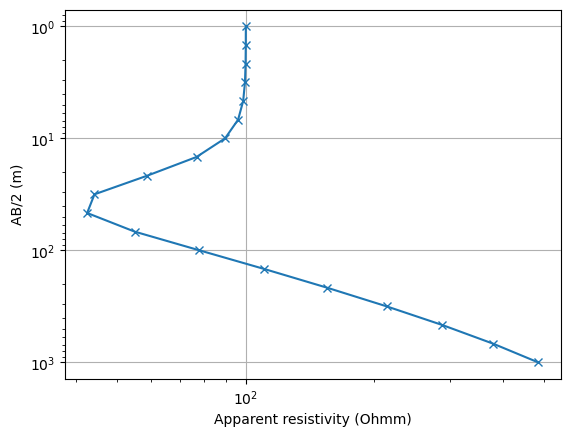

In [14]:
fig, ax = pg.plt.subplots()
ax.loglog(ves["rhoa"], ves["ab2"], "x-");
ax.set_ylim(ax.get_ylim()[::-1])
ax.grid(True)
ax.set_xlabel("Apparent resistivity (Ohmm)")
ax.set_ylabel("AB/2 (m)");

In [15]:
ves.save("ves.data")
%pycat ves.data

0
# x y z
19
# ab2 mn2 rhoa valid 
1.00000000000000e+00    3.33333333333333e-01    9.99842595368026e+01    0
1.46779926762207e+00    4.89266422540690e-01    9.99504878923180e+01    0
2.15443469003188e+00    7.18144896677295e-01    9.98451992609077e+01    0
3.16227766016838e+00    1.05409255338946e+00    9.95221744616765e+01    0
4.64158883361278e+00    1.54719627787093e+00    9.85637180275876e+01    0
6.81292069057961e+00    2.27097356352654e+00    9.59046039427972e+01    0
1.00000000000000e+01    3.33333333333333e+00    8.94055443723811e+01    0
1.46779926762207e+01    4.89266422540690e+00    7.66315887818867e+01    0
2.15443469003188e+01    7.18144896677294e+00    5.87720534110749e+01    0
3.16227766016838e+01    1.05409255338946e+01    4.41998154306538e+01    0
4.64158883361278e+01    1.54719627787093e+01    4.24833204045250e+01    0
6.81292069057961e+01    2.27097356352654e+01    5.49158595510847e+01    0
1.00000000000000e+02    3.33333333333333e+01    7.78260521404922e+01    0
1.4

In [16]:
ves["flag"] = pg.Vector(ves["rhoa"] > 100) + 1
ves.save("ves.data")  # , "ab2 mn2 rhoa")
%pycat ves.data

0
# x y z
19
# ab2 flag mn2 rhoa valid 
1.00000000000000e+00    1.00000000000000e+00    3.33333333333333e-01    9.99842595368026e+01    0
1.46779926762207e+00    1.00000000000000e+00    4.89266422540690e-01    9.99504878923180e+01    0
2.15443469003188e+00    1.00000000000000e+00    7.18144896677295e-01    9.98451992609077e+01    0
3.16227766016838e+00    1.00000000000000e+00    1.05409255338946e+00    9.95221744616765e+01    0
4.64158883361278e+00    1.00000000000000e+00    1.54719627787093e+00    9.85637180275876e+01    0
6.81292069057961e+00    1.00000000000000e+00    2.27097356352654e+00    9.59046039427972e+01    0
1.00000000000000e+01    1.00000000000000e+00    3.33333333333333e+00    8.94055443723811e+01    0
1.46779926762207e+01    1.00000000000000e+00    4.89266422540690e+00    7.66315887818867e+01    0
2.15443469003188e+01    1.00000000000000e+00    7.18144896677294e+00    5.87720534110749e+01    0
3.16227766016838e+01    1.00000000000000e+00    1.05409255338946e+01    4.4199

In [17]:
print(ves)

Data: Sensors: 0 data: 19, nonzero entries: ['ab2', 'flag', 'mn2', 'rhoa']


In [18]:
ves["flag"]

19 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]

In [19]:
ves.markValid(ves["ab2"] > 2)
ves.save("ves.data", "ab2 rhoa")  # note that only valid data are saved!
print(ves)

Data: Sensors: 0 data: 19, nonzero entries: ['ab2', 'flag', 'mn2', 'rhoa', 'valid']


## Data containers with indexed data 
Assume we have data associate with a transmitter, receivers and a property U.

In [20]:
data = pg.DataContainer()
data.registerSensorIndex("Tx")
data.registerSensorIndex("Rx")
print(data)

Data: Sensors: 0 data: 0, nonzero entries: ['Rx', 'Tx']


In [21]:
# Create a list of 10 sensors, 2m spacing
for x in np.arange(10):
    data.createSensor([x*2, 0])
print(data)

Data: Sensors: 10 data: 0, nonzero entries: ['Rx', 'Tx']


In [22]:
data["Rx"] = np.arange(12)
# data["Tx"] = np.arange(9) # well catched
data["Tx"] = pg.Vector(data.size(), 2)
print(data)
data.save("TxRx.data");
%pycat TxRx.data

Data: Sensors: 10 data: 12, nonzero entries: ['Rx', 'Tx']


10
# x y z
0       0       0
2       0       0
4       0       0
6       0       0
8       0       0
10      0       0
12      0       0
14      0       0
16      0       0
18      0       0
12
# Rx Tx valid 
1       3       0
2       3       0
3       3       0
4       3       0
5       3       0
6       3       0
7       3       0
8       3       0
9       3       0
10      3       0
11      3       0
12      3       0
0


In [23]:
data.markValid(data["Rx"])
print(data["valid"])
print(data["Rx"])

12 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[ 0  1  2  3  4  5  6  7  8  9 10 11]


In [24]:
data.checkDataValidity()
data.removeInvalid()
print(data)

Data: Sensors: 10 data: 10, nonzero entries: ['Rx', 'Tx', 'valid']


In [25]:
data.save("TxRx.data");
%pycat TxRx.data

10
# x y z
0       0       0
2       0       0
4       0       0
6       0       0
8       0       0
10      0       0
12      0       0
14      0       0
16      0       0
18      0       0
10
# Rx Tx valid 
1       3       1
2       3       1
3       3       1
4       3       1
5       3       1
6       3       1
7       3       1
8       3       1
9       3       1
10      3       1
0


In [26]:
sx = pg.x(data)
data["dist"] = np.abs(sx[data["Rx"]] - sx[data["Tx"]])
print(data["dist"])

10 [4.0, 2.0, 0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0]


In [27]:
# use only data where transmitter is not receiver
data.markInvalid(data["Rx"] == data["Tx"])
print(data)
data.save("TxRx.data");
%pycat TxRx.data

Data: Sensors: 10 data: 10, nonzero entries: ['Rx', 'Tx', 'dist', 'valid']


10
# x y z
0       0       0
2       0       0
4       0       0
6       0       0
8       0       0
10      0       0
12      0       0
14      0       0
16      0       0
18      0       0
10
# Rx Tx dist valid 
1       3       4.00000000000000e+00    1
2       3       2.00000000000000e+00    1
3       3       0.00000000000000e+00    0
4       3       2.00000000000000e+00    1
5       3       4.00000000000000e+00    1
6       3       6.00000000000000e+00    1
7       3       8.00000000000000e+00    1
8       3       1.00000000000000e+01    1
9       3       1.20000000000000e+01    1
10      3       1.40000000000000e+01    1
0


In [28]:
data.removeInvalid()
print(data)

Data: Sensors: 10 data: 9, nonzero entries: ['Rx', 'Tx', 'dist', 'valid']


In [29]:
data.createSensor(data.sensors()[-1])
print(data)  # no change

Data: Sensors: 10 data: 9, nonzero entries: ['Rx', 'Tx', 'dist', 'valid']


In [30]:
data.createSensor(data.sensors()[-1]+0.1)
print(data)
data.save("TxRx.data")
%pycat TxRx.data

Data: Sensors: 11 data: 9, nonzero entries: ['Rx', 'Tx', 'dist', 'valid']


11
# x y z
0       0       0
2       0       0
4       0       0
6       0       0
8       0       0
10      0       0
12      0       0
14      0       0
16      0       0
18      0       0
18.1    0.1     0.1
9
# Rx Tx dist valid 
1       3       4.00000000000000e+00    1
2       3       2.00000000000000e+00    1
4       3       2.00000000000000e+00    1
5       3       4.00000000000000e+00    1
6       3       6.00000000000000e+00    1
7       3       8.00000000000000e+00    1
8       3       1.00000000000000e+01    1
9       3       1.20000000000000e+01    1
10      3       1.40000000000000e+01    1
0


Could not set x/y label:  9 [0.0, 1.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0] 9 [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]


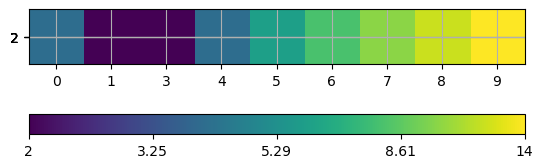

In [31]:
pg.viewer.mpl.showDataContainerAsMatrix(data, "Rx", "Tx", "dist");

In [32]:
data.remove(data["dist"] > 11)
print(data)

Data: Sensors: 11 data: 7, nonzero entries: ['Rx', 'Tx', 'dist', 'valid']


In [33]:
data["dist"]

7 [4.0, 2.0, 2.0, 4.0, 6.0, 8.0, 10.0]

In [34]:
data.scale([2, 1])
data.translate([10, 0])
data.save("TxRx.data")
%pycat TxRx.data

11
# x y z
10      0       0
14      0       0
18      0       0
22      0       0
26      0       0
30      0       0
34      0       0
38      0       0
42      0       0
46      0       0
46.2    0.1     0
7
# Rx Tx dist valid 
1       3       4.00000000000000e+00    1
2       3       2.00000000000000e+00    1
4       3       2.00000000000000e+00    1
5       3       4.00000000000000e+00    1
6       3       6.00000000000000e+00    1
7       3       8.00000000000000e+00    1
8       3       1.00000000000000e+01    1
0


In [35]:
data["Rx"][5] = data["Rx"][4]

In [36]:
data.removeUnusedSensors()
print(data)

Data: Sensors: 8 data: 7, nonzero entries: ['Rx', 'Tx', 'dist', 'valid']


In [37]:
data.removeSensorIdx(2)
print(data)

Data: Sensors: 7 data: 6, nonzero entries: ['Rx', 'Tx', 'dist', 'valid']


In [38]:
data.save("TxRx.data")
%pycat TxRx.data

7
# x y z
14      0       0
18      0       0
22      0       0
26      0       0
30      0       0
34      0       0
38      0       0
6
# Rx Tx dist valid 
1       2       2.00000000000000e+00    1
3       2       2.00000000000000e+00    1
4       2       4.00000000000000e+00    1
5       2       6.00000000000000e+00    1
6       2       8.00000000000000e+00    1
7       2       1.00000000000000e+01    1
0


## The mesh class
The mesh class holds geometric definitions (piece-wise linear complex - PLC) or discretizations of the subsurface. It contains of nodes, boundaries (edges in 2D, faces in 3D) and cells (triangles, quadrangles, hexahedra, tetrahedra) with associated markers and arbitrary data for nodes or cells.

https://www.pygimli.org/_tutorials_auto/1_basics/plot_2-anatomy_of_a_mesh.html gives a good overview.

We construct a mesh by creating nodes and cells.

In [39]:
mesh = pg.Mesh(2)  # 2D
n11 = mesh.createNode((0.0, 0.0))
n12 = mesh.createNode((1.0, 0.0))
n13 = mesh.createNode((2.0, 0.0))
n21 = mesh.createNode((0.0, 1.0))
n22 = mesh.createNode((1.0, 1.0), marker=1)
n23 = mesh.createNode((2.0, 1.0))
n31 = mesh.createNode((0.5, 1.7))
n32 = mesh.createNode((1.5, 1.7))
mesh.createQuadrangle(n11, n12, n22, n21, marker=4)
mesh.createQuadrangle(n12, n13, n23, n22, marker=4)
mesh.createTriangle(n21, n22, n31, marker=3)  
mesh.createTriangle(n22, n23, n32, marker=3)  
mesh.createTriangle(n31, n32, n22, marker=3)  # leave out
print(mesh)

Mesh: Nodes: 8 Cells: 5 Boundaries: 0


In [40]:
mesh.createNeighborInfos()
print(mesh)

Mesh: Nodes: 8 Cells: 5 Boundaries: 12


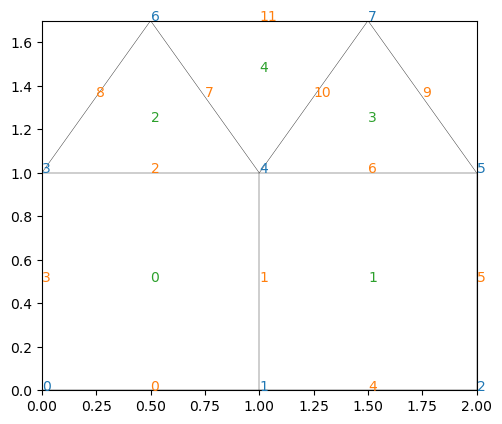

In [41]:
ax, _ = pg.show(mesh, showMesh=True)
for n in mesh.nodes(): 
    ax.text(n.x(), n.y(), str(n.id()), color="C0")
for b in mesh.boundaries(): 
    ax.text(b.center().x(), b.center().y(), str(b.id()), color="C1")
for c in mesh.cells(): 
    ax.text(c.center().x(), c.center().y(), str(c.id()), color="C2")    

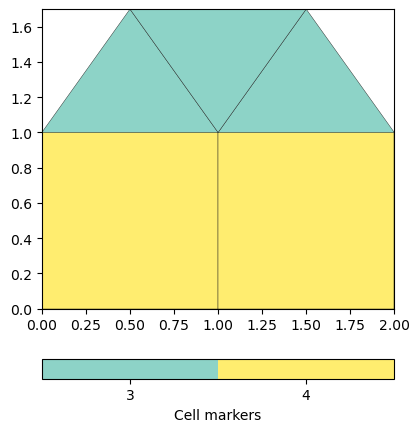

In [42]:
pg.show(mesh, markers=True, showMesh=True);

In [43]:
for n in mesh.nodes():
    print(n.id(), n.pos())

0 RVector3: (0.0, 0.0, 0.0)
1 RVector3: (1.0, 0.0, 0.0)
2 RVector3: (2.0, 0.0, 0.0)
3 RVector3: (0.0, 1.0, 0.0)
4 RVector3: (1.0, 1.0, 0.0)
5 RVector3: (2.0, 1.0, 0.0)
6 RVector3: (0.5, 1.7, 0.0)
7 RVector3: (1.5, 1.7, 0.0)


In [44]:
for c in mesh.cells():
    print(c.id(), len(c.nodes()), c.center())

0 4 RVector3: (0.5, 0.5, 0.0)
1 4 RVector3: (1.5, 0.5, 0.0)
2 3 RVector3: (0.5, 1.2333333333333334, 0.0)
3 3 RVector3: (1.5, 1.2333333333333334, 0.0)
4 3 RVector3: (1.0, 1.4666666666666668, 0.0)


In [45]:
for b in mesh.boundaries():
    print(b.id(), ": Nodes:", b.ids(), end=" ")
    if not b.outside():
        left = b.leftCell()
        right = b.rightCell()
        print(left.id(), right.id())
    print()

0 : Nodes: 2 [0, 1] 
1 : Nodes: 2 [1, 4] 0 1

2 : Nodes: 2 [4, 3] 0 2

3 : Nodes: 2 [3, 0] 
4 : Nodes: 2 [1, 2] 
5 : Nodes: 2 [2, 5] 
6 : Nodes: 2 [5, 4] 1 3

7 : Nodes: 2 [4, 6] 2 4

8 : Nodes: 2 [6, 3] 
9 : Nodes: 2 [5, 7] 
10 : Nodes: 2 [7, 4] 3 4

11 : Nodes: 2 [6, 7] 


We visualize some related property and attribute it the mesh cells.

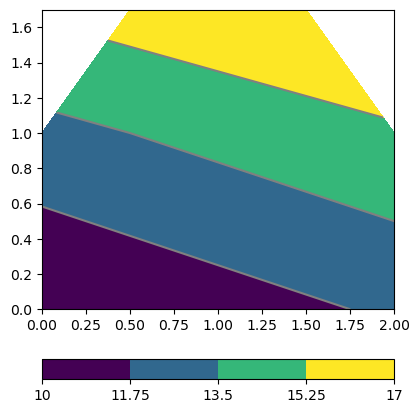

In [46]:
voltage = np.arange(mesh.nodeCount()) + 10
pg.show(mesh, voltage);

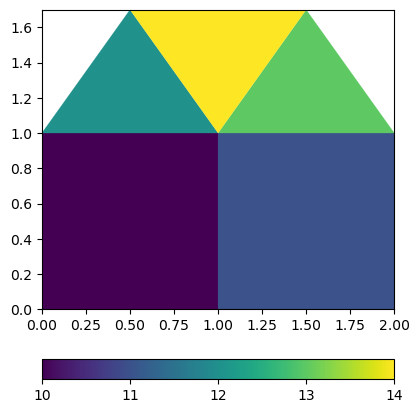

In [47]:
mesh["velocity"] = np.arange(mesh.cellCount()) + 10
pg.show(mesh, mesh["velocity"]);

In [48]:
mesh.exportVTK("mesh.vtk")
%pycat mesh.vtk

# vtk DataFile Version 3.0
d-2__ created by libgimli-v1.4.0
ASCII
DATASET UNSTRUCTURED_GRID
POINTS 8 double
0       0       0
1       0       0
2       0       0
0       1       0
1       1       0
2       1       0
0.5     1.7     0
1.5     1.7     0
CELLS 5 22
4       0       1       4       3       
4       1       2       5       4       
3       3       4       6       
3       4       5       7       
3       6       7       4       
CELL_TYPES 5
9 9 5 5 5 
CELL_DATA 5
SCALARS Marker double 1
LOOKUP_TABLE default
4 4 3 3 3 
SCALARS velocity double 1
LOOKUP_TABLE default
10 11 12 13 14 
POINT_DATA 8


## Matrices

There is a large number of Matrix types that are all derived from the base class `MatrixBase`. 
They do not have to store elements but can be logical or wrappers. 
They just have to provide the functions `A.cols()`, `A.rows()` (column and row numbers), `A.mult(x)`$=A\cdot x$ and `A.transMult(y)`$=A^T\cdot y$.

#### Dense matrix `Matrix`
All elements are stored column-wise, i.e. all rows `A[i]` are of type `pg.Vector`. 
This matrix is used for storing dense data (like ERT Jacobians) and doing simple algebra.

In [49]:
A = pg.Matrix(3, 4)
A[0, 0] = 1
A[2, 2] = -1
A[1] = np.arange(4)
print(A)
x = np.arange(4) + 5
A*x

RMatrix: 3 x 4
4 [1.0, 0.0, 0.0, 0.0]
4 [0.0, 1.0, 2.0, 3.0]
4 [0.0, 0.0, -1.0, 0.0]



3 [5.0, 44.0, -7.0]

Exists also as complex matrix under `pg.matrix.CMatrix`.

#### Index-based sparse matrix `SparseMapMatrix`
Sparse matrix (most elements are zero) with single access and.
Typical for traveltime Jacobian (only certain cells covered by individual rays) or constraint matrices.

2 [2.0, 1.0]


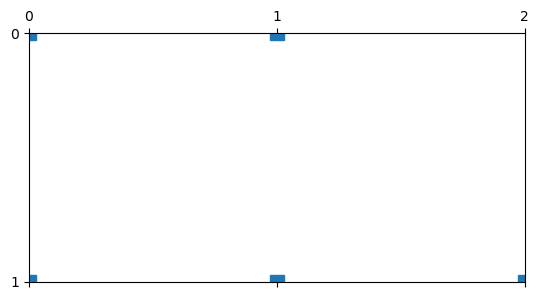

In [50]:
A = pg.SparseMapMatrix(2, 3)
A.setVal(0, 0, -1)
A.setVal(0, 1, +1)  # first-order derivative
A.setVal(1, 0, -1)
A.setVal(1, 1, +2)
A.setVal(1, 2, -1)  # second-order derivative
x = [10, 12, 13]
print(A * x)
pg.show(A);

Exists also as complex-valued variant under `pg.matrix.CSparseMapMatrix`.

#### Column-compressed matrix `SparseMatrix` 
Used for numerical approximation of partial differential equations like finite-element or finite volume. Not typically used unless efficiency is of importance. It exists also complex-valued as `pg.matrix.CSparseMatrix`.

#### Diagonal matrices
First, there is an identity matrix `IdentityMatrix`. No elements stored at all. Important for constraint matrices when combined into `BlockMatrix` (see below). More generally, there is a diagonal matrix `DiagonalMatrix` where only the diagonal is stored as vector.

In [51]:
A = pg.matrix.IdentityMatrix(3)  # , 2.0)
x = [10, 11, 12]
A*x

3 [10.0, 11.0, 12.0]

#### Weighted matrices `MultLeftMatrix`/`MultRightMatrix`/`MultLeftRightMatrix`
Often, matrices are weighted from either side by a vector, e.g. data error weighting of the Jacobian matrix, data and model transformations, or weighting individual smoothness parts according to the roughness so that only the weighting is changed and not the matrix.

In [52]:
A = pg.Matrix(3, 4)
A += 1
w = [2, 3, -1]
B = pg.matrix.MultLeftMatrix(A, w)
x = np.arange(4)
print(A*x)
print(B*x)

3 [6.0, 6.0, 6.0]
3 [12.0, 18.0, -6.0]


#### Combinations of matrices
Logical matrices can combine different other matrices (of arbitrary type) avoiding double memory storage by multiplication (`Mult2Matrix`) or addition (`Add2Matrix`).

In [53]:
A = pg.Matrix(2, 3)
A += 1
B = pg.SparseMapMatrix(3, 4)
C = pg.matrix.Mult2Matrix(A, B)
x = np.arange(4)
C * x

2 [0.0, 0.0]

#### Block matrices
The most important type is the `BlockMatrix`, where arbitrary matrices are combined into a logical matrix. This is of importance for inversion frameworks:
* joint inversion: Jacobian matrices are concatenated
* combination of different constrains: combining different regularization
* laterally, spatially or temporally constrained inversion: regularization between model cells of each frame but also between the frames
Note that the matrices only have to be defined once and can appear multiply.

pg.matrix.BlockMatrix of size 6 x 7 consisting of 4 submatrices.


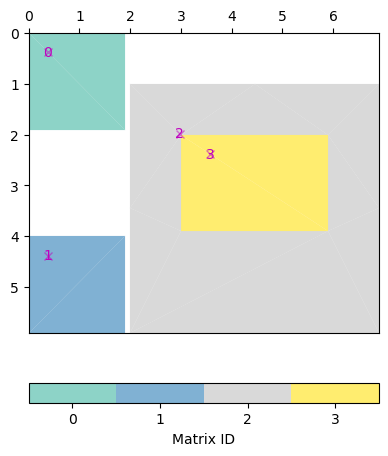

In [54]:
A = pg.BlockMatrix()
A1 = pg.Matrix(2, 2)
A.addMatrix(A1, 0, 0)
A.addMatrix(A1, 4, 0, scale=2.0)
A2 = pg.matrix.IdentityMatrix(5)
A.addMatrix(A2, 1, 2)
A3 = pg.SparseMapMatrix(2, 3)
A.addMatrix(A3, 2, 3)
print(A)
pg.show(A);

There are also simpler types of matrix combinations:
* `H2Matrix`/`V2Matrix`: two matrices below/next to each other
* `HNMatrix`/`VNMatrix`: one matrix repeated N times horizontally/vertically
* `NDMatrix`: block diagonal matrix 

#### Geostatistical constraint matrix
For geostatistical constraints, a correlation matrix is computed using correlation lengths and angles to define their directions. To access its inverse root in a way that avoids matrix inversion, an eigenvalue decomposition is done and the eigenvalues $D$ and -vectors $Q$ are stored so that the operator 
$$C^{-0.5}\cdot x=Q\cdot D^{-0.5}\cdot Q^T \cdot x$$

Jordi, C., Doetsch, J., Günther, T., Schmelzbach, C. & Robertsson, J.O.A. (2018): Geostatistical regularisation
operators for geophysical inverse problems on irregular meshes. Geophysical Journal International 213, 1374-
1386, doi:10.1093/gji/ggy055.

### This tutorial
We will touch all these things in the following notebooks. We will mainly focus on ERT, but the concepts hold for other methods as well. Main focus today is on the subject of regularization in pyGIMLi.